In [1]:
!pip3 install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 2.9 MB/s 
     |████████████████████████████████| 4.0 MB 10.0 MB/s 
     |████████████████████████████████| 62 kB 1.3 MB/s 
     |████████████████████████████████| 112 kB 68.2 MB/s 
     |████████████████████████████████| 128 kB 74.6 MB/s 
     |████████████████████████████████| 110 kB 42.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [2]:
"""
Note about the trading programs in this course
The trading programs we show are very idealized.
For example:
We do not consider limits in leverage or initial investment and 
this is idealistic since in reality there are limits to both as our pockets are not infinitely deep.
We do not consider trading costs etc. Again this is idealistic.
We assume it is possible to invest in an infinitesimally small fraction of a stock. Again this is idealistic. 
Later on, we will address how to limit some of these assumptions.
Because of all these assumptions impact profits and profits are not linear, 
our trading programs cannot be used to calculate profits realistically, rather
they are used to give an idea of profit to risk ratio, accuracy etc
"""

'\nNote about the trading programs in this course\nThe trading programs we show are very idealized.\nFor example:\nWe do not consider limits in leverage or initial investment and \nthis is idealistic since in reality there are limits to both as our pockets are not infinitely deep.\nWe do not consider trading costs etc. Again this is idealistic.\nWe assume it is possible to invest in an infinitesimally small fraction of a stock. Again this is idealistic.\xa0\nLater on, we will address how to limit some of these assumptions.\nBecause of all these assumptions impact profits and profits are not linear, \nour trading programs cannot be used to calculate profits realistically, rather\nthey are used to give an idea of profit to risk ratio, accuracy etc\n'

In [3]:
import WhiteRealityCheckFor1 #you can ignore this for now
import detrendPrice #you can ignore this fornow
import pandas as pd
import numpy as np
from datetime import datetime
pd.core.common.is_list_like = pd.api.types.is_list_like #datareader problem probably fixed in next version of datareader
from pandas_datareader import data as pdr
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import os
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import keras.backend as K
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM
np.random.seed(7)

In [4]:
yf.pdr_override() # <== that's all it takes :-)

start_date = '2015-12-1' 
end_date = '2019-12-1' 
#end_date = datetime.now() 

symbol = 'NFLX' 
msg = "" 
address = symbol + '.csv'

In [5]:
try:
    dfP = pdr.get_data_netflix(symbol, start=start_date, end=end_date)
    dfP.to_csv(address, header = True, index=True, encoding='utf-8') 
except Exception:
    msg = "Netflix problem"
    dfP = pd.DataFrame()

dfP = pd.read_csv(address, parse_dates=['Date'])
dfP = dfP.sort_values(by='Date')
dfP.set_index('Date', inplace = True)

In [6]:
df = pd.read_csv('/content/NFLX.csv', header=0)
print(df.shape)
print(df.describe())
print(df.isnull().any())
fig = px.line(df, x='Date', y='Close')
fig.show()

(1007, 7)
              Open         High          Low        Close    Adj Close  \
count  1007.000000  1007.000000  1007.000000  1007.000000  1007.000000   
mean    224.768352   228.028351   221.168431   224.727051   224.727051   
std     103.529167   105.082007   101.682306   103.433882   103.433882   
min      80.570000    84.699997    79.949997    82.790001    82.790001   
25%     124.730000   126.349998   122.910000   124.935001   124.935001   
50%     195.570007   197.089996   193.770004   195.539993   195.539993   
75%     325.529999   330.835007   318.869995   325.220001   325.220001   
max     421.380005   423.209991   413.079987   418.970001   418.970001   

             Volume  
count  1.007000e+03  
mean   9.873956e+06  
std    6.461739e+06  
min    1.616300e+06  
25%    5.618500e+06  
50%    8.008400e+06  
75%    1.201745e+07  
max    5.841040e+07  
Date         False
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume     

In [7]:
ohlc_data = df.iloc[:, 1:5]
ohlc_avg = ohlc_data.mean(axis=1)
hlc_avg = df[['High', 'Low', 'Close']].mean(axis=1)
close = df.Close

In [8]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(x = df.index, y = ohlc_avg,
                  name='OHLC avg'))
fig1.add_trace(go.Scatter(x = df.index, y = hlc_avg,
                  name='HLC avg'))
fig1.add_trace(go.Scatter(x = df.index, y = close,
                  name='close column data'))
fig1.show()

In [9]:
new_data = pd.DataFrame(index=range(0,len(df)), columns=['Date', 'ohlc_avg'])
for i in range(0, len(df)):
  new_data['Date'][i] = df['Date'][i]
  new_data['ohlc_avg'][i] = ohlc_avg[i]

In [10]:
# setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

In [11]:
ds = new_data.values

In [12]:
# we will take 80% data in train and remaining in test
train = int(len(new_data)*0.8)
test = len(new_data) - train
train, test = new_data.iloc[0:train,:], new_data.iloc[train:len(new_data),:]

In [13]:
# we have normalize the data cuz data is like 149...., 488..something like that
# so we have to normalize betwwen 0 and 1
scalar = MinMaxScaler(feature_range=(0, 1))
scaled_data = scalar.fit_transform(ds)

In [14]:
# splitting the data to x_train, y_train
# we will first train upto 60 and then predict on 61 and then 
# we will train from 61 to 120 then predict on 121 likewise we will go
x_train, y_train = [], []
for i in range(60, len(train)):
  x_train.append(scaled_data[i-60:i,0])
  y_train.append(scaled_data[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [15]:
# now we have reshape the array to 3-d to pass the data into lstm [number of samples, time steps/batch_size, features] 
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [16]:
# create and fit the lstm network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.25))
model.add(LSTM(units=50))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

In [17]:
model.fit(x_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
24/24 [==============================] - 8s 130ms/step - loss: 0.0458
Epoch 2/50
24/24 [==============================] - 3s 145ms/step - loss: 0.0034
Epoch 3/50
24/24 [==============================] - 4s 152ms/step - loss: 0.0021
Epoch 4/50
24/24 [==============================] - 4s 152ms/step - loss: 0.0022
Epoch 5/50
24/24 [==============================] - 4s 148ms/step - loss: 0.0019
Epoch 6/50
24/24 [==============================] - 4s 159ms/step - loss: 0.0021
Epoch 7/50
24/24 [==============================] - 4s 159ms/step - loss: 0.0020
Epoch 8/50
24/24 [==============================] - 4s 156ms/step - loss: 0.0021
Epoch 9/50
24/24 [==============================] - 4s 180ms/step - loss: 0.0018
Epoch 10/50
24/24 [==============================] - 4s 168ms/step - loss: 0.0019
Epoch 11/50
24/24 [==============================] - 3s 121ms/step - loss: 0.0017
Epoch 12/50
24/24 [==============================] - 1s 60ms/step - loss: 0.0017
Epoch 13/50
24/24 [=======

In [18]:
# predicting 920 values, using past 60 from the train data
inputs = new_data[len(new_data)-len(test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = scalar.transform(inputs)

In [19]:
x_test = []
for i in range(60,inputs.shape[0]):
    x_test.append(inputs[i-60:i,0])
x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [20]:
predicted_price = model.predict(x_test)
# inverse transform for getting back all normal values from scaled values
predicted_price = scalar.inverse_transform(predicted_price)

rms=np.sqrt(np.mean(np.power((test-predicted_price),2)))

7/7 [==============================] - 1s 21ms/step


In [21]:
# create a new column of predicted values
test['Prediction'] = predicted_price

<ipython-input-21-b88fea727ff8>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [22]:
# Graph for comparing the results of model predicted and original value
fig2 = go.Figure()

fig2.add_trace(go.Scatter(x = train.index, y = train.ohlc_avg,
                  name='train'))
fig2.add_trace(go.Scatter(x = test.index, y = test.ohlc_avg,
                  name='test_ohlc_avg'))
fig2.add_trace(go.Scatter(x = test.index, y = test.Prediction,
                  name='test'))
fig2.show()

In [23]:
fig3 = px.line(df, x='Date', y='Close')
fig3.show()

In [24]:
dfP['42d'] = np.round(dfP['Close'].rolling(window=42).mean(),2)
dfP['252d'] = np.round(dfP['Close'].rolling(window=252).mean(),2)

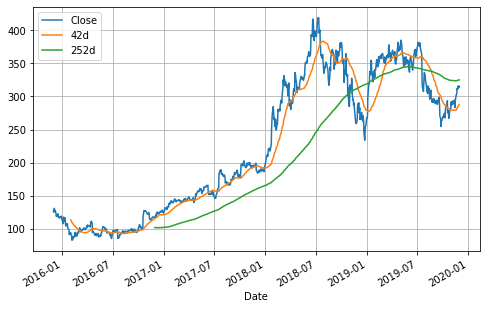

In [25]:
dfP[['Close','42d','252d']].plot(grid=True,figsize=(8,5))
dfP['42-252'] = dfP['42d'] - dfP['252d']

In [26]:
dfP['pct_rets'] = (dfP['Close']/dfP['Close'].shift(1))-1

In [27]:
X = 0

In [28]:
dfP['Stance'] = np.where((dfP['42-252'] > X), 1, 0)
dfP['Stance'] = np.where(dfP['42-252'] < X, -1, dfP['Stance'])

In [29]:
dfP['syst_rets'] = dfP['pct_rets'] * dfP['Stance'].shift(1) #using percent returns
dfP['syst_cum_rets'] = (dfP['syst_rets']+1).cumprod()-1+1 #using percent returns to get cumulative
dfP['mkt_cum_rets'] = ((dfP['pct_rets']+1).cumprod())-1+1 #using percent returns to get cumulative

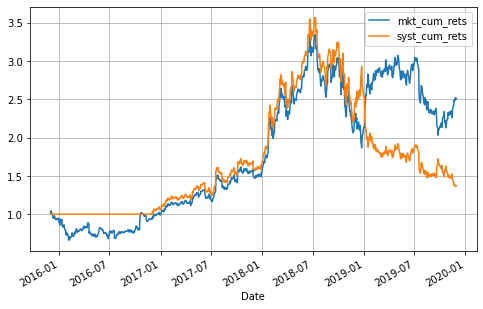

In [30]:
dfP[['mkt_cum_rets','syst_cum_rets']].plot(grid=True,figsize=(8,5)) #plotting returns percent cumul

In [31]:
start = 1 # or should start at dfP['sys_cum_rets.iloc].iloc[2]

start_val = start
end_val = dfP['syst_cum_rets'].iat[-1]

In [32]:
start_date = dfP.iloc[0].name
end_date = dfP.iloc[-1].name
days = (end_date - start_date).days 

In [33]:
periods = 360 #360 accounting days

TotalAnnReturn = (end_val-start_val)/start_val/(days/periods)

years = days/periods
CAGR = ((((end_val/start_val)**(1/years)))-1)

In [34]:
try:
    sharpe =  sharpe =  (dfP['syst_rets'].mean()/dfP['syst_rets'].std()) * np.sqrt(periods)
except ZeroDivisionError:
    sharpe = 0.0

In [35]:
print ("TotalAnnReturn in percent = %f" %(TotalAnnReturn*100))
print ("CAGR in percent = %f" %(CAGR*100))
print ("Sharpe Ratio = %f" %(round(sharpe,2)))

TotalAnnReturn in percent = 9.084915
CAGR in percent = 8.042212
Sharpe Ratio = 0.480000


average return -0.002097
[-0.00433821  0.00405262]
Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)
p_value:
0.8256


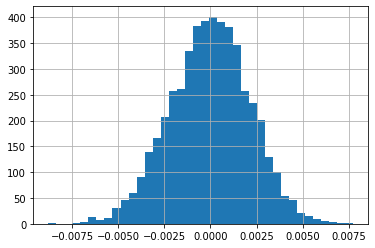

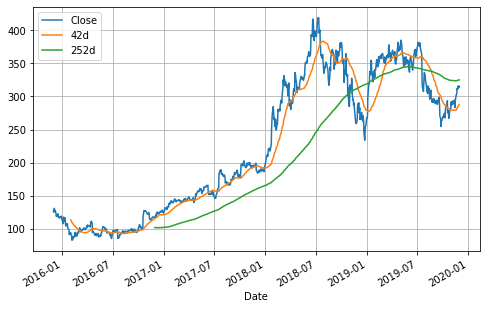

In [36]:
#white reality check
#Detrend prices before calculating detrended returns
dfP['DetClose'] = detrendPrice.detrendPrice(dfP.Close).values #you can ignore this for now
#these are the detrended returns to be fed to White's Reality Check
dfP['Det_pct_rets']= (dfP['DetClose']- dfP['DetClose'].shift(1)) / dfP['DetClose'].shift(1) #you can ignore this for now
dfP['Det_syst_rets']= dfP['Det_pct_rets']*dfP['Stance'].shift(1) #you can ignore this for now
WhiteRealityCheckFor1.bootstrap(dfP.Det_syst_rets) #you can ignore this for now
dfP[['Close','42d','252d']].plot(grid=True,figsize=(8,5))
dfP.to_csv(r'Results\dfP_simple_MACO.csv')

## Simple Moving Average

In [37]:
dfP = dfP['Close'].to_frame()
dfP['SMA30'] = dfP['Close'].rolling(30).mean()
print(dfP['SMA30'])
 
# removing all the NULL values using
# dropna() method
dfP.dropna(inplace=True)

Date
2015-12-01           NaN
2015-12-02           NaN
2015-12-03           NaN
2015-12-04           NaN
2015-12-07           NaN
                 ...    
2019-11-22    288.494999
2019-11-25    289.495665
2019-11-26    290.436998
2019-11-27    291.425332
2019-11-29    292.135665
Name: SMA30, Length: 1007, dtype: float64


In [38]:
dfP

,Close,SMA30
Date,,
2016-01-13,106.559998,118.929333
2016-01-14,107.059998,118.318999
2016-01-15,104.040001,117.489333
2016-01-19,107.889999,116.858666
2016-01-20,107.739998,116.085667
...,...,...
2019-11-22,310.480011,288.494999
2019-11-25,315.549988,289.495665
2019-11-26,312.489990,290.436998


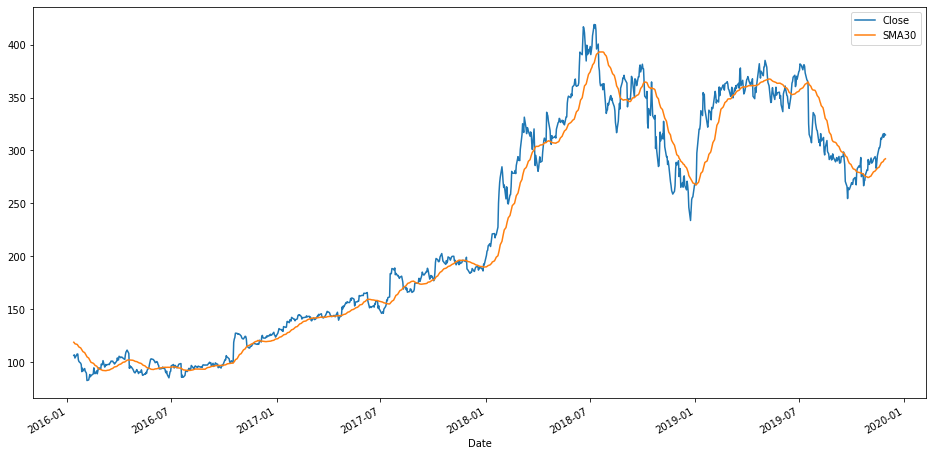

In [39]:
dfP[['Close', 'SMA30']].plot(label='NETFLIX',
                                  figsize=(16, 8))

## MACD (Moving Average Convergence Divergence)

In [40]:
exp1 = dfP['Close'].ewm(span=12, adjust=False).mean()
exp2 = dfP['Close'].ewm(span=26, adjust=False).mean()
dfP['MACD'] = exp1 - exp2
print(dfP['MACD'])
dfP['Signal line'] = dfP['MACD'].ewm(span=9, adjust=False).mean()

Date
2016-01-13    0.000000
2016-01-14    0.039886
2016-01-15   -0.170230
2016-01-19   -0.025789
2016-01-20    0.075705
                ...   
2019-11-22    6.735301
2019-11-25    7.527500
2019-11-26    7.818283
2019-11-27    8.231423
2019-11-29    8.359994
Name: MACD, Length: 978, dtype: float64


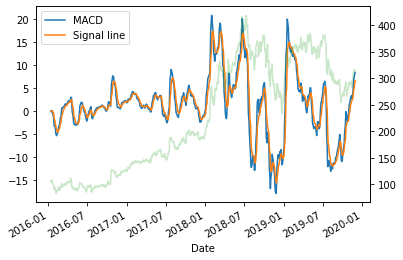

In [41]:
fig, ax = plt.subplots()
dfP[['MACD', 'Signal line']].plot(ax=ax)
dfP['Close'].plot(ax=ax, alpha=0.25, secondary_y=True)